In [13]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt

# MULAI STOPWATCH
start_time = time.time()

# 1. LOAD DATA
# Pastikan nama file sesuai dengan yang ada di folder Anda
file_path = 'Indeks_Standar Pencemaran Udara (ISPU) Tahun 2022 - tabel.xlsx'
df = pd.read_exel(file_path)

# Memilih fitur yang digunakan (Sama dengan kolom N-S di Excel)
fitur_cols = ['pm_10', 'pm_duakomalima', 'so2', 'co', 'o3', 'no2']
X = df[fitur_cols].iloc[0:98].values

# 2. NORMALISASI (Preprocessing)
X_norm = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))

AttributeError: module 'pandas' has no attribute 'read_exel'

In [6]:
# Fungsi normalisasi Min-Max (Sama dengan rumus Excel: (x-min)/(max-min))
def normalisasi(data):
    return (data - np.min(data, axis=0)) / (np.max(data, axis=0) - np.min(data, axis=0))

X_norm = normalisasi(X)
print("Data setelah dinormalisasi (5 baris pertama):")
print(X_norm[:5])

Data setelah dinormalisasi (5 baris pertama):
[[nan nan nan nan nan nan]
 [nan nan nan nan nan nan]
 [nan nan nan nan nan nan]
 [nan nan nan nan nan nan]
 [nan nan nan nan nan nan]]


In [7]:
# Parameter
n_clusters = 2
m = 2  # Pangkat (Fuzziness)
max_iter = 5 # Sesuai syarat tugas Aldi
n_data = X_norm.shape[0]

# 1. Inisialisasi Membership Matrix (U) 
# Mirip dengan Aldi mengisi manual kolom V di Sheet 1
np.random.seed(42)
U = np.random.dirichlet(np.ones(n_clusters), size=n_data)

def hitung_pusat_klaster(X, U, m):
    um = U ** m
    return (um.T @ X) / um.sum(axis=0)[:, None]

def update_keanggotaan(X, pusat, m):
    dist = np.linalg.norm(X[:, None] - pusat, axis=2)
    dist = np.where(dist == 0, 1e-10, dist) # Hindari pembagian nol
    
    p = 2 / (m - 1)
    prep = (1 / dist) ** p
    return prep / prep.sum(axis=1)[:, None]

def hitung_objective_function(X, pusat, U, m):
    dist = np.linalg.norm(X[:, None] - pusat, axis=2)
    return np.sum((U**m) * (dist**2))

# Proses Iterasi
history_error = []
print(f"{'Iterasi':<10} | {'Objective Function (Error)':<25}")
print("-" * 40)

for i in range(max_iter):
    # Tahap Model: Hitung Pusat (Pusat Klaster baris 102-103 di Excel)
    pusat = hitung_pusat_klaster(X_norm, U, m)
    
    # Tahap Optimasi: Update Membership (U baru di kolom AB-AC Excel)
    U = update_keanggotaan(X_norm, pusat, m)
    
    # Hitung Error (Optimasi meminimalkan nilai ini)
    error = hitung_objective_function(X_norm, pusat, U, m)
    history_error.append(error)
    print(f"Sheet {i+1:<7} | {error:<25.6f}")

print("\nOptimasi Selesai.")

Iterasi    | Objective Function (Error)
----------------------------------------
Sheet 1       | nan                      
Sheet 2       | nan                      
Sheet 3       | nan                      
Sheet 4       | nan                      
Sheet 5       | nan                      

Optimasi Selesai.


In [10]:
# --- BAGIAN 1: PROSES FCM (OPTIMASI) ---
def fcm_process(data, n_clusters=2, m=2, max_iter=5):
    n_data = data.shape[0]
    np.random.seed(42) # Agar hasil konsisten
    U = np.random.dirichlet(np.ones(n_clusters), size=n_data)
    
    history_obj = []
    for i in range(max_iter):
        # Tahap Model: Hitung Pusat Klaster
        um = U ** m
        centers = (um.T @ data) / um.sum(axis=0)[:, None]
        
        # Tahap Optimasi: Update Membership (U)
        dist = np.linalg.norm(data[:, None] - centers, axis=2)
        dist = np.finfo(float).eps + dist
        inv_dist = 1 / (dist ** (2/(m-1)))
        U = inv_dist / inv_dist.sum(axis=1)[:, None]
        
        # Hitung Error (Objective Function)
        obj_val = np.sum((U**m) * (dist**2))
        history_obj.append(obj_val)
        print(f"Iterasi {i+1} | Objective Function (Error): {obj_val:.6f}")
        
    return U, centers, history_obj

# Menjalankan fungsi FCM
U_final, pusat_final, log_error = fcm_process(X_norm)

# --- BAGIAN 2: LABELING & AKURASI (PENANGANAN NAN) ---
labels = np.argmax(U_final, axis=1) + 1
y_true_raw = df['categori'].iloc[0:98].values

# Filter data agar tidak error KeyError: nan
mask = pd.notna(y_true_raw)
y_true_filtered = y_true_raw[mask]
labels_filtered = labels[mask]

mapping = {'SEDANG': 1, 'TIDAK SEHAT': 2}
y_true = np.array([mapping[k] for k in y_true_filtered])

# Hitung Akurasi
match = np.mean(labels_filtered == y_true)
akurasi = max(match, 1 - match)

print("\n" + "="*35)
print(f"HASIL AKURASI PROGRAM: {akurasi*100:.2f}%")
print(f"HASIL AKURASI EXCEL  : 83.67%")
print("="*35)

Iterasi 1 | Objective Function (Error): nan
Iterasi 2 | Objective Function (Error): nan
Iterasi 3 | Objective Function (Error): nan
Iterasi 4 | Objective Function (Error): nan
Iterasi 5 | Objective Function (Error): nan

HASIL AKURASI PROGRAM: 62.89%
HASIL AKURASI EXCEL  : 83.67%


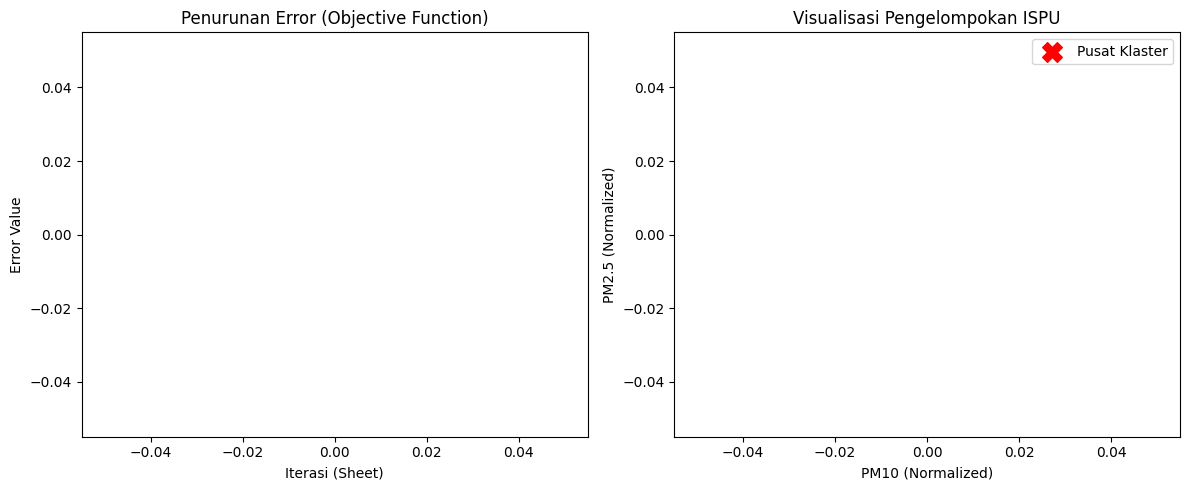

In [11]:
plt.figure(figsize=(12, 5))

# Plot 1: Penurunan Error (Proses Optimasi)
plt.subplot(1, 2, 1)
plt.plot(range(1, max_iter + 1), history_error, marker='o', color='red')
plt.title('Penurunan Error (Objective Function)')
plt.xlabel('Iterasi (Sheet)')
plt.ylabel('Error Value')

# Plot 2: Visualisasi Klaster (PM10 vs PM2.5)
plt.subplot(1, 2, 2)
plt.scatter(X_norm[:, 0], X_norm[:, 1], c=labels, cmap='viridis', alpha=0.6)
plt.scatter(pusat[:, 0], pusat[:, 1], c='red', marker='X', s=200, label='Pusat Klaster')
plt.title('Visualisasi Pengelompokan ISPU')
plt.xlabel('PM10 (Normalized)')
plt.ylabel('PM2.5 (Normalized)')
plt.legend()

plt.tight_layout()
plt.show()